# Single System Price Forecasting
Author: George Panagiotou

In [1]:
import pandas as pd
import numpy as np
from comp_utils import *
import lightgbm as lgb
import os
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import make_scorer
import os
import lightgbm as lgb
import optuna
from sklearn.metrics import make_scorer
import numpy as np

## Load Train data:

In [4]:
train_weather_feat = pd.read_hdf('data/DAP/train_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
train_weather_feat = train_weather_feat.drop(columns=columns_to_drop)

demand_pred = pd.read_csv('data/Demand/Demand_quantiles_train_set.csv')
demand_pred.rename(columns={'time': 'valid_time'}, inplace=True)
demand_pred['valid_time'] = pd.to_datetime(demand_pred['valid_time'], utc=True)
demand_pred.drop(['ND'], axis=1, inplace=True)

energy_data = pd.read_hdf("data/combined/train_energy_data_20200920_20240519.h5", 'df')

# Merge the datasets
train_table = pd.merge(demand_pred, train_weather_feat, on='valid_time', how='left')
train_table = pd.merge(train_table, energy_data, left_on='valid_time', right_on='dtm', how='left')

# Create lagged features for SS_Price at 3, 4, 5, 6, and 7 days before
for i in range(3, 15):
    train_table[f'SS_Price_lag_{i}d'] = train_table['SS_Price'].shift(i * 24)

# Drop rows with NaN values in any of the lagged columns
train_table.dropna(inplace=True)

# Extract target variable after handling NaNs
train_target_variable = train_table['SS_Price']
train_times = train_table['valid_time']

# Define the IQR method for detecting outliers
Q1 = train_target_variable.quantile(0.25)
Q3 = train_target_variable.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with extreme SSP values
train_table = train_table[(train_target_variable >= lower_bound) & (train_target_variable <= upper_bound)]

# Update the target variable to reflect the filtered table
train_target_variable = train_table['SS_Price']
train_times = train_table['valid_time']

# Drop unwanted columns
train_table.drop(['DA_Price', 'dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 
                  'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 
                  'Availability1', 'Availability2', 'Availability3'], axis=1, inplace=True)

print(train_table.shape)


(50897, 93)


In [5]:
train_weather_feat = pd.read_hdf('data/DAP/train_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
train_weather_feat = train_weather_feat.drop(columns=columns_to_drop)

demand_pred = pd.read_csv('data/TradingTrackData/Demand_quantiles_cv_set.csv')
demand_pred.rename(columns={'time': 'valid_time'}, inplace=True)
demand_pred['valid_time'] = pd.to_datetime(demand_pred['valid_time'], utc=True)
demand_pred.drop(['ND'], axis=1, inplace=True)

energy_data = pd.read_hdf("data/combined/train_energy_data_20200920_20240519.h5", 'df')

# Merge the datasets
cv_table = pd.merge(demand_pred, train_weather_feat, on='valid_time', how='left')
cv_table = pd.merge(cv_table, energy_data, left_on='valid_time', right_on='dtm', how='left')

# Create lagged features for SS_Price at 3, 4, 5, 6, and 7 days before
cv_table['SS_Price_lag_3d'] = cv_table['SS_Price'].shift(3 * 24)
cv_table['SS_Price_lag_4d'] = cv_table['SS_Price'].shift(4 * 24)
cv_table['SS_Price_lag_5d'] = cv_table['SS_Price'].shift(5 * 24)
cv_table['SS_Price_lag_6d'] = cv_table['SS_Price'].shift(6 * 24)
cv_table['SS_Price_lag_7d'] = cv_table['SS_Price'].shift(7 * 24)
cv_table['SS_Price_lag_8d'] = cv_table['SS_Price'].shift(8 * 24)
cv_table['SS_Price_lag_9d'] = cv_table['SS_Price'].shift(9 * 24)
cv_table['SS_Price_lag_10d'] = cv_table['SS_Price'].shift(10 * 24)
cv_table['SS_Price_lag_11d'] = cv_table['SS_Price'].shift(11 * 24)
cv_table['SS_Price_lag_12d'] = cv_table['SS_Price'].shift(12 * 24)
cv_table['SS_Price_lag_13d'] = cv_table['SS_Price'].shift(13 * 24)
cv_table['SS_Price_lag_14d'] = cv_table['SS_Price'].shift(14 * 24)
# Drop rows with NaN values in any of the lagged columns
cv_table.dropna(inplace=True)

# Extract target variable after handling NaNs
cv_target_variable = cv_table['SS_Price']
cv_times= cv_table['valid_time']
# Drop unwanted columns
cv_table.drop(['DA_Price', 'dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 
                  'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 
                  'Availability1', 'Availability2', 'Availability3'], axis=1, inplace=True)

print(cv_table.shape)

(5615, 93)


## Load Test data:

In [7]:
test_weather_feat = pd.read_hdf('data/DAP/test_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
test_weather_feat = test_weather_feat.drop(columns=columns_to_drop)

demand_pred_test = pd.read_csv('data/Demand/Demand_predictions_test_set.csv')
demand_pred_test.rename(columns={'time':'valid_time'}, inplace=True)
demand_pred_test['valid_time'] = pd.to_datetime(demand_pred_test['valid_time'], utc=True)
demand_pred_test.drop(['ND'], axis=1, inplace=True)
demand_pred_test.dropna(inplace=True)
print(demand_pred_test.shape)

energy_data_test = pd.read_hdf("data/combined/test_energy_data_20200920_20240519.h5", 'df')
energy_data_test['dtm'] = pd.to_datetime(energy_data_test['dtm'], utc=True)
energy_data_test['SS_Price_lag_3d'] = energy_data_test['SS_Price'].shift(3 * 24)
energy_data_test['SS_Price_lag_4d'] = energy_data_test['SS_Price'].shift(4 * 24)
energy_data_test['SS_Price_lag_5d'] = energy_data_test['SS_Price'].shift(5 * 24)
energy_data_test['SS_Price_lag_6d'] = energy_data_test['SS_Price'].shift(6 * 24)
energy_data_test['SS_Price_lag_7d'] = energy_data_test['SS_Price'].shift(7 * 24)
energy_data_test['SS_Price_lag_8d'] = energy_data_test['SS_Price'].shift(8 * 24)
energy_data_test['SS_Price_lag_9d'] = energy_data_test['SS_Price'].shift(9 * 24)
energy_data_test['SS_Price_lag_10d'] = energy_data_test['SS_Price'].shift(10 * 24)
energy_data_test['SS_Price_lag_11d'] = energy_data_test['SS_Price'].shift(11 * 24)
energy_data_test['SS_Price_lag_12d'] = energy_data_test['SS_Price'].shift(12 * 24)
energy_data_test['SS_Price_lag_13d'] = energy_data_test['SS_Price'].shift(13 * 24)
energy_data_test['SS_Price_lag_14d'] = energy_data_test['SS_Price'].shift(14 * 24)

# Merge the datasets
test_table = pd.merge(demand_pred_test, test_weather_feat, on='valid_time', how='left')
test_table = pd.merge(test_table, energy_data_test, left_on='valid_time', right_on='dtm', how='left')

test_times = test_table['valid_time']
test_target_variable = test_table['SS_Price']

# Drop unwanted columns
test_table.drop(['DA_Price', 'dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 
                 'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 
                 'Availability1', 'Availability2', 'Availability3'], axis=1, inplace=True)
print(test_table.shape)



(4318, 10)
(4318, 93)


## Transforming time into cyclic features:
We need to transform UTC datetime feature into numbers, thus we choose to convert datetime to cyclic features 

In [8]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

cv_table = add_cyclic_features(cv_table)
cv_table = cv_table.drop(columns=["valid_time"])
print('CV features after adding cyclic times and removing valid_time:', cv_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (50897, 101)
CV features after adding cyclic times and removing valid_time: (5615, 101)
Test features after adding cyclic times and removing valid_time: (4318, 101)


### LightGBRegressor (Tuning)

In [7]:
# Directory for saving models
saved_models_dir = 'models/DAP'
os.makedirs(saved_models_dir, exist_ok=True)

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_params_dict = {}
best_models = {}

# Function to compute pinball loss
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Objective function for Optuna
def objective(trial, quantile, initial_params=None):
    if initial_params:
        params = initial_params
    else:
        params = {
            'objective': 'quantile',
            'alpha': quantile,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'max_depth': trial.suggest_int('max_depth', -7, 7),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e3, log=True),
            'verbose': -1
        }

    model = lgb.LGBMRegressor(**params)

    model.fit(train_table, train_target_variable)
    preds = model.predict(cv_table)
    
    # Calculate pinball loss on the CV set
    loss = pinball_loss(cv_target_variable, preds, alpha=quantile)
    
    return loss

# Train a model for each quantile with Optuna
for quantile in quantiles:
    print(f"Starting optimization for quantile {quantile}")
    study = optuna.create_study(direction='minimize')
    
    # Initial parameters for the first trial
    initial_params = {
        'objective': 'quantile',
        'alpha': quantile,
        'learning_rate': 0.1,
        'max_depth': -4,
        'n_estimators': 150,
        'num_leaves': 60,
        'min_child_weight': 1e-2,
        'verbose': -1
    }
    
    # Run the first trial
    study.enqueue_trial(initial_params)
    
    # Run further trials
    study.optimize(lambda trial: objective(trial, quantile), n_trials=50)
    
    best_params = study.best_params
    best_params['objective'] = 'quantile'
    best_params['alpha'] = quantile
    
    # Train the model with the best parameters
    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        train_table, train_target_variable,
        eval_set=[(cv_table, cv_target_variable)],
        eval_metric='quantile'
    )
    
    # Save the model
    model_path = f'{saved_models_dir}/SSP_Tuned_q{int(quantile * 100)}.txt'
    model.booster_.save_model(model_path)
    
    # Store the best params and model
    best_params_dict[quantile] = best_params
    best_models[quantile] = model
    
    print(f"Finished optimization for quantile {quantile}")
    print(f"Best parameters for quantile {quantile}: {best_params}")

# Print the last training loss for each quantile after all models have been trained
for quantile, model in best_models.items():
    last_loss = model.evals_result_['valid_0']['quantile'][-1]
    print(f"Last CV loss for quantile {quantile}: {last_loss}")

[I 2024-08-20 20:33:01,591] A new study created in memory with name: no-name-4306603d-be08-49fd-aa8e-3f357f85a939


Starting optimization for quantile 0.1


[I 2024-08-20 20:33:02,654] Trial 0 finished with value: 6.771996712558415 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 6.771996712558415.
[I 2024-08-20 20:33:04,245] Trial 1 finished with value: 7.154414404801195 and parameters: {'learning_rate': 0.017142029689303367, 'max_depth': -6, 'n_estimators': 234, 'num_leaves': 57, 'min_child_weight': 21.650188373417418}. Best is trial 0 with value: 6.771996712558415.
[I 2024-08-20 20:33:05,600] Trial 2 finished with value: 7.54792853168393 and parameters: {'learning_rate': 0.014207480796497975, 'max_depth': -3, 'n_estimators': 149, 'num_leaves': 86, 'min_child_weight': 0.0020603031870837217}. Best is trial 0 with value: 6.771996712558415.
[I 2024-08-20 20:33:07,071] Trial 3 finished with value: 6.968031621193262 and parameters: {'learning_rate': 0.033410920094708606, 'max_depth': 0, 'n_estimators': 186, 'num_leaves': 68, 'min_child_weight'

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 27.980003


[I 2024-08-20 20:34:17,335] A new study created in memory with name: no-name-a6601bcd-9b1d-4d91-b182-9f2b59c572b5


Finished optimization for quantile 0.1
Best parameters for quantile 0.1: {'learning_rate': 0.05085430423749896, 'max_depth': -3, 'n_estimators': 203, 'num_leaves': 97, 'min_child_weight': 75.5041174984559, 'objective': 'quantile', 'alpha': 0.1}
Starting optimization for quantile 0.2


[I 2024-08-20 20:34:18,877] Trial 0 finished with value: 10.986221668191824 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 10.986221668191824.
[I 2024-08-20 20:34:21,173] Trial 1 finished with value: 10.846423506001344 and parameters: {'learning_rate': 0.049517834437674484, 'max_depth': -5, 'n_estimators': 229, 'num_leaves': 97, 'min_child_weight': 0.011969583957319549}. Best is trial 1 with value: 10.846423506001344.
[I 2024-08-20 20:34:21,484] Trial 2 finished with value: 12.267641543280293 and parameters: {'learning_rate': 0.07177988657463999, 'max_depth': 7, 'n_estimators': 55, 'num_leaves': 22, 'min_child_weight': 436.9124965238693}. Best is trial 1 with value: 10.846423506001344.
[I 2024-08-20 20:34:24,042] Trial 3 finished with value: 10.560649851592359 and parameters: {'learning_rate': 0.09094761965321779, 'max_depth': -7, 'n_estimators': 262, 'num_leaves': 92, 'min_child_weig

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 50.349998


[I 2024-08-20 20:35:41,896] A new study created in memory with name: no-name-162194e4-fd09-4bdf-ac94-522430fef642


Finished optimization for quantile 0.2
Best parameters for quantile 0.2: {'learning_rate': 0.14683080535527462, 'max_depth': 0, 'n_estimators': 293, 'num_leaves': 87, 'min_child_weight': 69.06471944552543, 'objective': 'quantile', 'alpha': 0.2}
Starting optimization for quantile 0.3


[I 2024-08-20 20:35:43,015] Trial 0 finished with value: 14.069781132345275 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 14.069781132345275.
[I 2024-08-20 20:35:43,584] Trial 1 finished with value: 15.318865527051303 and parameters: {'learning_rate': 0.06462655147110445, 'max_depth': 4, 'n_estimators': 182, 'num_leaves': 33, 'min_child_weight': 167.2883827578264}. Best is trial 0 with value: 14.069781132345275.
[I 2024-08-20 20:35:45,051] Trial 2 finished with value: 13.713548681693103 and parameters: {'learning_rate': 0.0954250205710446, 'max_depth': -5, 'n_estimators': 192, 'num_leaves': 63, 'min_child_weight': 0.010263261383991416}. Best is trial 2 with value: 13.713548681693103.
[I 2024-08-20 20:35:47,404] Trial 3 finished with value: 14.942886230889513 and parameters: {'learning_rate': 0.014334769788285353, 'max_depth': -7, 'n_estimators': 261, 'num_leaves': 80, 'min_child_weig

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 65.099998


[I 2024-08-20 20:37:06,388] A new study created in memory with name: no-name-cd0794de-a826-4bfc-8b01-a0ca9a8934b7


Finished optimization for quantile 0.3
Best parameters for quantile 0.3: {'learning_rate': 0.14268076023180237, 'max_depth': -1, 'n_estimators': 290, 'num_leaves': 96, 'min_child_weight': 3.1820879818466405, 'objective': 'quantile', 'alpha': 0.3}
Starting optimization for quantile 0.4


[I 2024-08-20 20:37:07,524] Trial 0 finished with value: 16.000305964208653 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 16.000305964208653.
[I 2024-08-20 20:37:08,081] Trial 1 finished with value: 18.41550557467884 and parameters: {'learning_rate': 0.03660104596989191, 'max_depth': 3, 'n_estimators': 228, 'num_leaves': 90, 'min_child_weight': 2.4236347166068692}. Best is trial 0 with value: 16.000305964208653.
[I 2024-08-20 20:37:10,222] Trial 2 finished with value: 16.784613710632883 and parameters: {'learning_rate': 0.022895392893025876, 'max_depth': -7, 'n_estimators': 255, 'num_leaves': 70, 'min_child_weight': 0.44263905633416517}. Best is trial 0 with value: 16.000305964208653.
[I 2024-08-20 20:37:10,494] Trial 3 finished with value: 20.535552846176127 and parameters: {'learning_rate': 0.010915663543983992, 'max_depth': 1, 'n_estimators': 85, 'num_leaves': 22, 'min_child_weigh

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 80.000000


[I 2024-08-20 20:38:39,260] A new study created in memory with name: no-name-b38d5a24-d52f-418f-bc31-2c7f4032b319


Finished optimization for quantile 0.4
Best parameters for quantile 0.4: {'learning_rate': 0.1320973109480312, 'max_depth': -3, 'n_estimators': 260, 'num_leaves': 97, 'min_child_weight': 37.33911227483487, 'objective': 'quantile', 'alpha': 0.4}
Starting optimization for quantile 0.5


[I 2024-08-20 20:38:40,345] Trial 0 finished with value: 16.997869354637615 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 16.997869354637615.
[I 2024-08-20 20:38:40,706] Trial 1 finished with value: 21.0383443216569 and parameters: {'learning_rate': 0.02249341677912605, 'max_depth': 3, 'n_estimators': 129, 'num_leaves': 28, 'min_child_weight': 0.5048225673149097}. Best is trial 0 with value: 16.997869354637615.
[I 2024-08-20 20:38:41,189] Trial 2 finished with value: 18.801836682520232 and parameters: {'learning_rate': 0.06483981871203484, 'max_depth': -7, 'n_estimators': 98, 'num_leaves': 26, 'min_child_weight': 0.0033057145449225003}. Best is trial 0 with value: 16.997869354637615.
[I 2024-08-20 20:38:42,863] Trial 3 finished with value: 17.995227090565468 and parameters: {'learning_rate': 0.03055287320302325, 'max_depth': -5, 'n_estimators': 277, 'num_leaves': 44, 'min_child_weigh

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 99.050003


[I 2024-08-20 20:40:04,045] A new study created in memory with name: no-name-dc8eda1b-8a0f-4021-a242-8ddcdf8f542d


Finished optimization for quantile 0.5
Best parameters for quantile 0.5: {'learning_rate': 0.12420931534383993, 'max_depth': -4, 'n_estimators': 284, 'num_leaves': 92, 'min_child_weight': 0.05597110034947446, 'objective': 'quantile', 'alpha': 0.5}
Starting optimization for quantile 0.6


[I 2024-08-20 20:40:05,147] Trial 0 finished with value: 16.65724916704891 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 16.65724916704891.
[I 2024-08-20 20:40:06,164] Trial 1 finished with value: 19.30949893649698 and parameters: {'learning_rate': 0.02009365727141817, 'max_depth': -2, 'n_estimators': 95, 'num_leaves': 88, 'min_child_weight': 86.2560702414139}. Best is trial 0 with value: 16.65724916704891.
[I 2024-08-20 20:40:07,105] Trial 2 finished with value: 17.01918807775793 and parameters: {'learning_rate': 0.08157648990123231, 'max_depth': -1, 'n_estimators': 95, 'num_leaves': 88, 'min_child_weight': 0.010855759317813227}. Best is trial 0 with value: 16.65724916704891.
[I 2024-08-20 20:40:07,707] Trial 3 finished with value: 20.016836674731405 and parameters: {'learning_rate': 0.017925070728023088, 'max_depth': -1, 'n_estimators': 63, 'num_leaves': 66, 'min_child_weight': 7.6

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 120.000000


[I 2024-08-20 20:41:35,775] A new study created in memory with name: no-name-b65856c9-258d-4122-9889-c3b9c43c4047


Finished optimization for quantile 0.6
Best parameters for quantile 0.6: {'learning_rate': 0.14951303636009664, 'max_depth': -2, 'n_estimators': 283, 'num_leaves': 97, 'min_child_weight': 272.6568966780483, 'objective': 'quantile', 'alpha': 0.6}
Starting optimization for quantile 0.7


[I 2024-08-20 20:41:36,922] Trial 0 finished with value: 14.959203433732366 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 14.959203433732366.
[I 2024-08-20 20:41:38,017] Trial 1 finished with value: 17.410180695473397 and parameters: {'learning_rate': 0.012806072004165335, 'max_depth': -7, 'n_estimators': 181, 'num_leaves': 40, 'min_child_weight': 1.5119585047927133}. Best is trial 0 with value: 14.959203433732366.
[I 2024-08-20 20:41:38,415] Trial 2 finished with value: 18.641810238737644 and parameters: {'learning_rate': 0.11641249862996535, 'max_depth': 1, 'n_estimators': 144, 'num_leaves': 60, 'min_child_weight': 13.042165090791158}. Best is trial 0 with value: 14.959203433732366.
[I 2024-08-20 20:41:39,260] Trial 3 finished with value: 15.926035099727525 and parameters: {'learning_rate': 0.05895600951542818, 'max_depth': -6, 'n_estimators': 92, 'num_leaves': 76, 'min_child_weigh

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 147.050003


[I 2024-08-20 20:43:02,638] A new study created in memory with name: no-name-17705243-6031-4b91-abbe-efaeeb52c8e2


Finished optimization for quantile 0.7
Best parameters for quantile 0.7: {'learning_rate': 0.1454694651661656, 'max_depth': -1, 'n_estimators': 278, 'num_leaves': 83, 'min_child_weight': 0.0028293369706577772, 'objective': 'quantile', 'alpha': 0.7}
Starting optimization for quantile 0.8


[I 2024-08-20 20:43:03,751] Trial 0 finished with value: 12.066047985730128 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 12.066047985730128.
[I 2024-08-20 20:43:05,014] Trial 1 finished with value: 11.745174571304863 and parameters: {'learning_rate': 0.1433175668239322, 'max_depth': -3, 'n_estimators': 131, 'num_leaves': 88, 'min_child_weight': 0.019320642235061178}. Best is trial 1 with value: 11.745174571304863.
[I 2024-08-20 20:43:07,187] Trial 2 finished with value: 13.102062244587703 and parameters: {'learning_rate': 0.013127847906850919, 'max_depth': -4, 'n_estimators': 215, 'num_leaves': 94, 'min_child_weight': 9.721967449654306}. Best is trial 1 with value: 11.745174571304863.
[I 2024-08-20 20:43:07,762] Trial 3 finished with value: 12.869648515571969 and parameters: {'learning_rate': 0.06603267516397013, 'max_depth': -4, 'n_estimators': 125, 'num_leaves': 25, 'min_child_wei

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 185.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-20 20:44:29,232] A new study created in memory with name: no-name-2e469e32-aacf-4333-be3e-74965ed7f757


Finished optimization for quantile 0.8
Best parameters for quantile 0.8: {'learning_rate': 0.12472989333559588, 'max_depth': -4, 'n_estimators': 248, 'num_leaves': 86, 'min_child_weight': 349.8192136383429, 'objective': 'quantile', 'alpha': 0.8}
Starting optimization for quantile 0.9


[I 2024-08-20 20:44:30,221] Trial 0 finished with value: 7.408281545087175 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 7.408281545087175.
[I 2024-08-20 20:44:32,011] Trial 1 finished with value: 7.248823259208572 and parameters: {'learning_rate': 0.09500660762800495, 'max_depth': 0, 'n_estimators': 265, 'num_leaves': 53, 'min_child_weight': 101.15288324438926}. Best is trial 1 with value: 7.248823259208572.
[I 2024-08-20 20:44:34,264] Trial 2 finished with value: 7.911234547404313 and parameters: {'learning_rate': 0.011402911671249284, 'max_depth': -4, 'n_estimators': 249, 'num_leaves': 85, 'min_child_weight': 6.914363005174599}. Best is trial 1 with value: 7.248823259208572.
[I 2024-08-20 20:44:34,747] Trial 3 finished with value: 9.771406000845506 and parameters: {'learning_rate': 0.012088478995626194, 'max_depth': -4, 'n_estimators': 78, 'num_leaves': 29, 'min_child_weight': 1.6

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23334
[LightGBM] [Info] Number of data points in the train set: 50897, number of used features: 101
[LightGBM] [Info] Start training from score 233.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

## Test set

In [10]:
quantile_predictions = {}
quantile_predictions['SS_Price'] = train_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/SSP_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(train_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='SS_Price'))

quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/TradingTrackData/SSP_quantiles_train_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

9.302368470269707


## Validation Set

In [11]:
quantile_predictions = {}
quantile_predictions['SS_Price'] = cv_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/SSP_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(cv_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='SS_Price'))

quantile_predictions_df['time'] = cv_times  
csv_file_path = 'data/TradingTrackData/SSP_quantiles_cv_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

11.553883087038983


## Test set

In [12]:
quantile_predictions = {}
quantile_predictions['SS_Price'] = test_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/SSP_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(test_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='SS_Price'))

quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/TradingTrackData/SSP_quantiles_test_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

9.843036376465768


## Plot Quantiles ( Probabilistic Forecasting) :

In [13]:
save_path = "plots/DAP/SSPlot.html"
graph_title = "Single-System-Price (SSP) Forecasting"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'SS_Price', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

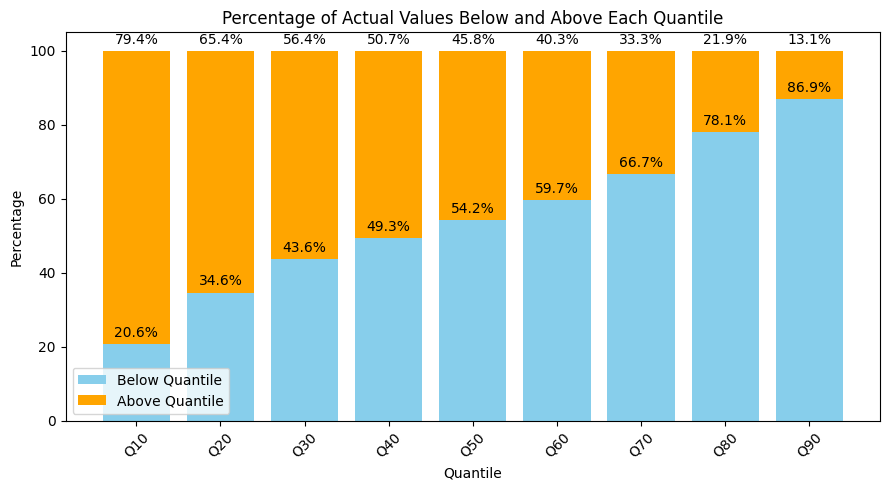

In [14]:
quantile_stats(quantile_predictions_df,'SS_Price')

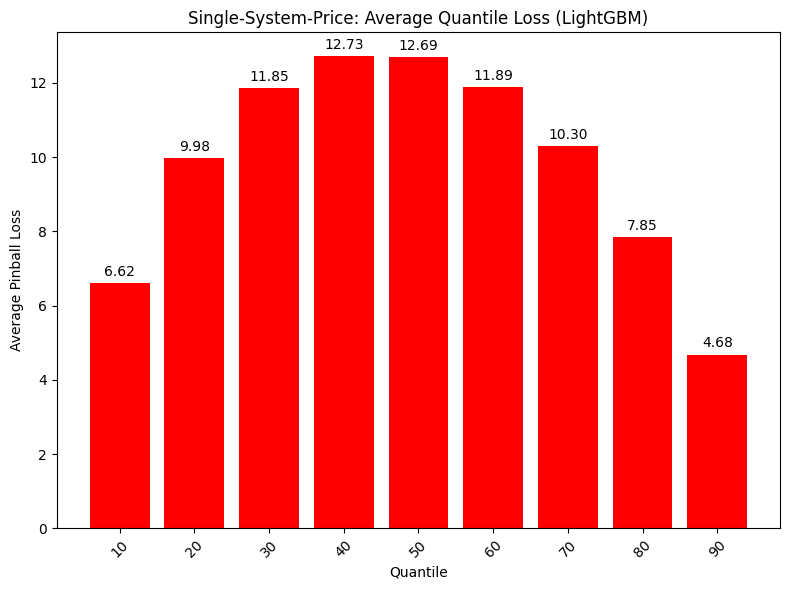

In [15]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'SS_Price', "Single-System-Price: Average Quantile Loss (LightGBM)")